In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from pathlib import Path
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

%matplotlib inline
pd.set_option('display.max_rows', 160)

data_dir = Path('data')
data = Path('survey-results-public.csv')

df = pd.read_csv(data_dir / data)
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 0. Initial EDA on the dataset

In [2]:
# Check the shape of data

num_rows = df.shape[0]
num_cols = df.shape[1]

print(f"# of rows: {num_rows}, # of cols: {num_cols}")

# of rows: 51392, # of cols: 154


In [3]:
# Check the columns and their dtypes of data

df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51392 entries, 0 to 51391
Data columns (total 154 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    Respondent                        int64  
 1    Professional                      object 
 2    ProgramHobby                      object 
 3    Country                           object 
 4    University                        object 
 5    EmploymentStatus                  object 
 6    FormalEducation                   object 
 7    MajorUndergrad                    object 
 8    HomeRemote                        object 
 9    CompanySize                       object 
 10   CompanyType                       object 
 11   YearsProgram                      object 
 12   YearsCodedJob                     object 
 13   YearsCodedJobPast                 object 
 14   DeveloperType                     object 
 15   WebDeveloperType                  object 
 16   MobileDeveloperType 

In [4]:
# Check the proportion of NULL values in each column

df.isnull().mean()

Respondent                          0.000000
Professional                        0.000000
ProgramHobby                        0.000000
Country                             0.000000
University                          0.000000
EmploymentStatus                    0.000000
FormalEducation                     0.000000
MajorUndergrad                      0.166388
HomeRemote                          0.143680
CompanySize                         0.242645
CompanyType                         0.244571
YearsProgram                        0.004806
YearsCodedJob                       0.204351
YearsCodedJobPast                   0.981048
DeveloperType                       0.297070
WebDeveloperType                    0.791874
MobileDeveloperType                 0.969781
NonDeveloperType                    0.904849
CareerSatisfaction                  0.169229
JobSatisfaction                     0.214352
ExCoderReturn                       0.982040
ExCoderNotForMe                     0.982079
ExCoderBal

In [5]:
# Check some interesting columns in detail
 
df['Professional'].value_counts()

Professional developer                                  36131
Student                                                  8224
Professional non-developer who sometimes writes code     5140
Used to be a professional developer                       983
None of these                                             914
Name: Professional, dtype: int64

In [6]:
df['MajorUndergrad'].value_counts()

Computer science or software engineering                        21409
Computer engineering or electrical/electronics engineering       4364
Computer programming or Web development                          3883
Information technology, networking, or system administration     2140
A natural science                                                1865
A non-computer-focused engineering discipline                    1789
Mathematics or statistics                                        1648
Something else                                                   1060
A humanities discipline                                           901
A business discipline                                             900
Management information systems                                    654
Fine arts or performing arts                                      646
A social science                                                  633
I never declared a major                                          592
Psychology          

<AxesSubplot:>

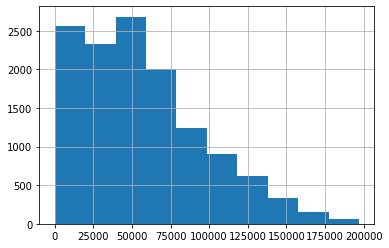

In [8]:
df['Salary'].hist()

<AxesSubplot:>

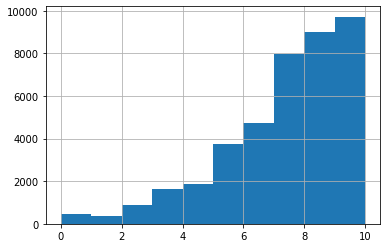

In [9]:
df['JobSatisfaction'].hist()

# 1. About Programming Language

In [51]:
# Get a subtable with selected columns and row only for Professional developer

target_columns = ['HaveWorkedLanguage', 'JobSatisfaction', 'Salary']
lang_df = df[df['Professional'] == 'Professional developer'][target_columns]
lang_df.head()

,HaveWorkedLanguage,JobSatisfaction,Salary
2,Java; PHP; Python,9.0,113750.0
4,NaN,8.0,NaN
7,CoffeeScript; Clojure; Elixir; Erlang; Haskell...,7.0,NaN
8,C#; JavaScript,6.0,NaN
9,Objective-C; Swift,8.0,NaN


In [17]:
lang_df['HaveWorkedLanguage'].value_counts()

C#; JavaScript; SQL                                                              1211
JavaScript; PHP; SQL                                                              983
Java                                                                              685
JavaScript                                                                        619
Java; JavaScript; SQL                                                             596
                                                                                 ... 
C++; C#; Java; JavaScript; Python; Ruby; SQL; Swift; VBA                            1
Objective-C; Swift; TypeScript                                                      1
Assembly; C++; Common Lisp; Haskell; Java; JavaScript; Matlab; Python; R; SQL       1
Haskell; Java; JavaScript; Matlab; SQL; Swift                                       1
Assembly; C; C++; Common Lisp; Go; Java; JavaScript; Perl; Python; SQL              1
Name: HaveWorkedLanguage, Length: 6472, dtype: int64

In [18]:
# Compute the number of programming language appears in the survey

languages = pd.Series(itertools.chain(*[x.split('; ') for x in lang_df['HaveWorkedLanguage'] if isinstance(x, str)]))
language_counts = languages.value_counts()
language_counts

JavaScript        18421
SQL               14836
Java              10586
C#                10129
Python             7613
PHP                7523
C++                5326
C                  4262
TypeScript         3117
Ruby               2614
Objective-C        2015
Swift              1892
VB.NET             1690
Go                 1272
Perl               1141
Scala              1110
Groovy             1052
Assembly           1017
CoffeeScript       1013
VBA                 967
R                   845
Matlab              793
Visual Basic 6      693
Lua                 628
Haskell             381
F#                  372
Elixir              315
Clojure             313
Rust                285
Smalltalk           247
Erlang              213
Common Lisp         151
Dart                108
Julia                71
Hack                 68
dtype: int64

In [93]:
pd.DataFrame(language_counts, columns=['Count'])

,Count
JavaScript,18421
SQL,14836
Java,10586
C#,10129
Python,7613
PHP,7523
C++,5326
C,4262
TypeScript,3117
Ruby,2614


In [19]:
language_rank = language_counts.rank(ascending=False)
language_rank

JavaScript         1.0
SQL                2.0
Java               3.0
C#                 4.0
Python             5.0
PHP                6.0
C++                7.0
C                  8.0
TypeScript         9.0
Ruby              10.0
Objective-C       11.0
Swift             12.0
VB.NET            13.0
Go                14.0
Perl              15.0
Scala             16.0
Groovy            17.0
Assembly          18.0
CoffeeScript      19.0
VBA               20.0
R                 21.0
Matlab            22.0
Visual Basic 6    23.0
Lua               24.0
Haskell           25.0
F#                26.0
Elixir            27.0
Clojure           28.0
Rust              29.0
Smalltalk         30.0
Erlang            31.0
Common Lisp       32.0
Dart              33.0
Julia             34.0
Hack              35.0
dtype: float64

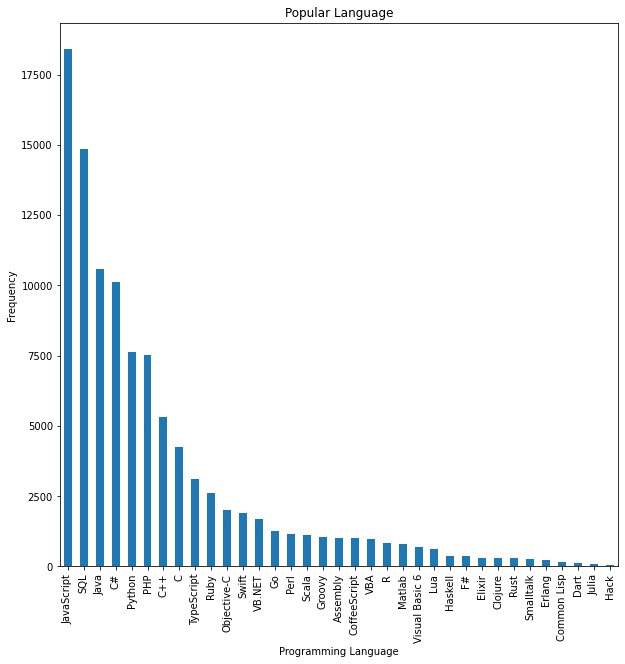

In [49]:
plt.figure(figsize=(10,10))
language_counts.plot(kind='bar');
plt.title('Popular Language');
plt.xlabel('Programming Language');
plt.ylabel('Frequency');

    For frequency, top 5 languages are Javascript, SQL, Java, C# and Python

In [23]:
lang_df_satisf = lang_df.dropna(subset=['JobSatisfaction'])
lang_df_satisf

,CareerSatisfaction,JobSatisfaction,HaveWorkedLanguage
2,8.0,9.0,Java; PHP; Python
4,6.0,8.0,NaN
7,7.0,7.0,CoffeeScript; Clojure; Elixir; Erlang; Haskell...
8,6.0,6.0,C#; JavaScript
9,6.0,8.0,Objective-C; Swift
...,...,...,...
51384,7.0,5.0,JavaScript
51386,7.0,4.0,C++; C#; Java; JavaScript; PHP; SQL
51387,7.0,3.0,C#; JavaScript; Python; SQL; VB.NET; VBA
51389,10.0,10.0,NaN


In [25]:
# Compute the average job satisfaction for each programming language

expand_df = pd.DataFrame(columns = ['JobSatisfaction', 'Language'])

for idx, row in lang_df_satisf.iterrows():
    job = row['JobSatisfaction']
    if isinstance(row['HaveWorkedLanguage'], str):
        lang = row['HaveWorkedLanguage'].split('; ')
        for l in lang:
            temp = {
                    'JobSatisfaction': [job], 
                    'Language': [l]}
            expand_df = expand_df.append(pd.DataFrame(temp))

In [26]:
job_mean = expand_df.groupby('Language').mean()['JobSatisfaction'].sort_values(ascending=False)
job_rank = job_mean.rank(ascending=False)

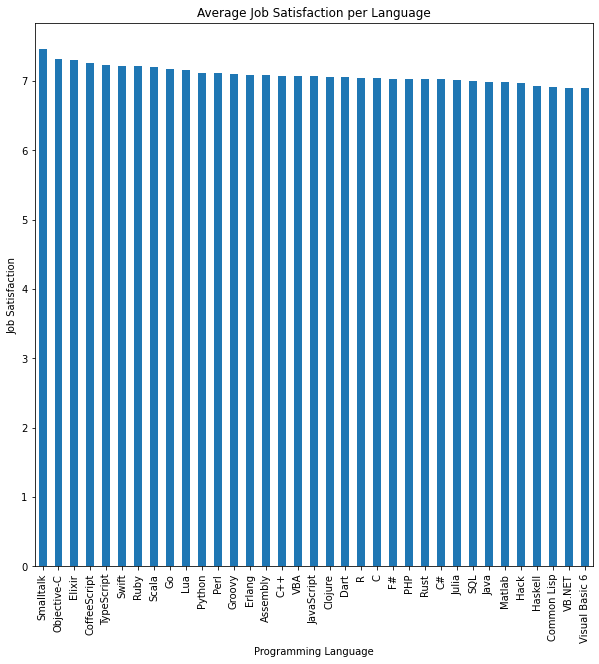

In [103]:
plt.figure(figsize=(10,10))
job_mean.plot(kind='bar');
plt.title('Average Job Satisfaction per Language');
plt.xlabel('Programming Language');
plt.ylabel('Job Satisfaction');

    For Job satisfaction, top 5 languages are SmallTalk. Objective-C, Elixir, CoffeeScript, TypeScript
    Python is located in 11th

In [30]:
lang_df_salary = lang_df.dropna(subset=['Salary'])
lang_df_salary

,HaveWorkedLanguage,JobSatisfaction,Salary
2,Java; PHP; Python,9.0,113750.000000
14,Assembly; C; C++,8.0,100000.000000
17,C; Clojure; JavaScript; Matlab; Rust; SQL; Swift,8.0,130000.000000
18,NaN,3.0,82500.000000
22,Java,9.0,100764.000000
...,...,...,...
51371,Go; JavaScript; Python,7.0,74193.548387
51378,JavaScript; Objective-C; Python; Swift,10.0,107526.881720
51382,C#; JavaScript; TypeScript,5.0,32258.064516
51387,C#; JavaScript; Python; SQL; VB.NET; VBA,3.0,58000.000000


In [32]:
# Compute the average salary for each programming language

salary_df = pd.DataFrame(columns = ['Language', 'Salary'])

for idx, row in lang_df_salary.iterrows():
    salary = row['Salary']
    if isinstance(row['HaveWorkedLanguage'], str):
        lang = row['HaveWorkedLanguage'].split('; ')
        for l in lang:
            temp = {'Salary': [salary], 
                    'Language': [l]}
            salary_df = salary_df.append(pd.DataFrame(temp))

In [33]:
salary_mean = salary_df.groupby('Language').mean()['Salary'].sort_values(ascending=False)
salary_rank = salary_mean.rank(ascending=False)

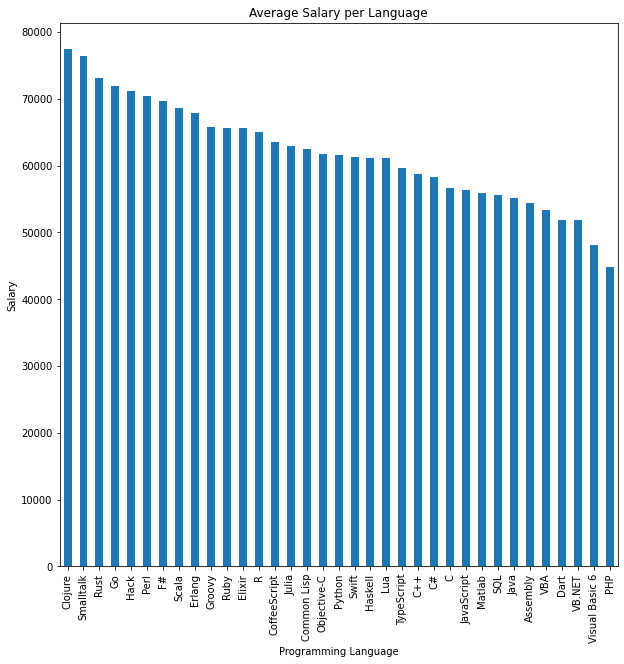

In [105]:
plt.figure(figsize=(10,10))
salary_mean.plot(kind='bar');
plt.title('Average Salary per Language');
plt.xlabel('Programming Language');
plt.ylabel('Salary');

    For Salary, top 5 languages are Clojure, Smalltalk, Rust, Go and Hack
    Python is located in the middle

In [41]:
avg_ranking_reciproacal = (3 / (job_rank + language_rank + salary_rank)).sort_values()
avg_ranking_reciproacal

Visual Basic 6    0.010870
Dart              0.011765
Common Lisp       0.012346
VB.NET            0.012500
Matlab            0.012658
Haskell           0.012987
Julia             0.013158
Hack              0.014085
VBA               0.014706
PHP               0.015385
Assembly          0.015873
Java              0.016393
SQL               0.017241
Rust              0.017544
F#                0.017857
C                 0.018182
R                 0.018182
Lua               0.018182
Erlang            0.018519
C#                0.018519
Clojure           0.020833
C++               0.021739
JavaScript        0.022222
Elixir            0.023810
Groovy            0.025000
Swift             0.027027
CoffeeScript      0.027027
TypeScript        0.027778
Python            0.029412
Perl              0.030303
Smalltalk         0.030303
Scala             0.031250
Objective-C       0.033333
Ruby              0.035714
Go                0.037037
dtype: float64

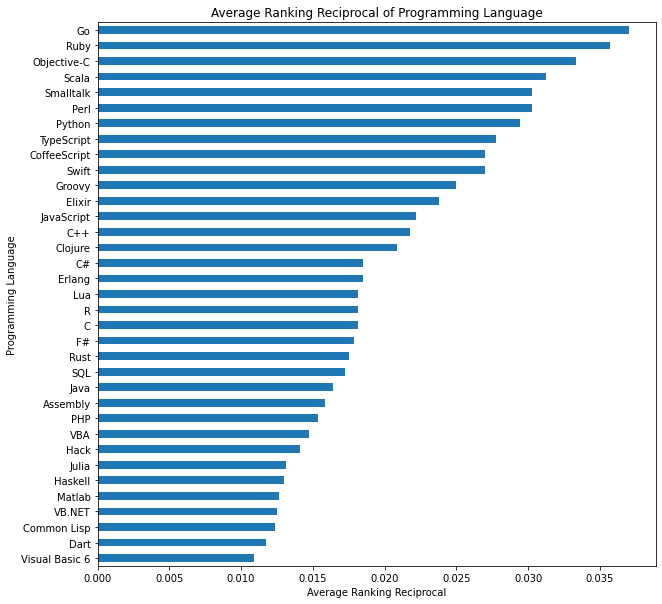

In [50]:
plt.figure(figsize=(10,10))
avg_ranking_reciproacal.plot(kind='barh');
plt.title('Average Ranking Reciprocal of Programming Language');
plt.xlabel('Average Ranking Reciprocal');
plt.ylabel('Programming Language');

# About Company

In [52]:
target = ['HomeRemote', 'CompanyType', 'CompanySize', 'JobSatisfaction']
comp_df = df.dropna(subset=['JobSatisfaction'])[target]
comp_df.head()

,HomeRemote,CompanyType,CompanySize,JobSatisfaction
2,"Less than half the time, but at least one day ...",Publicly-traded corporation,"10,000 or more employees",9.0
3,"Less than half the time, but at least one day ...",Non-profit/non-governmental organization or pr...,"10,000 or more employees",3.0
4,Never,"Privately-held limited company, not in startup...",10 to 19 employees,8.0
6,"Less than half the time, but at least one day ...",Government agency or public school/university,20 to 99 employees,6.0
7,All or almost all the time (I'm full-time remote),Pre-series A startup,Fewer than 10 employees,7.0


In [84]:
def get_avg_satisfaction(df, target):
    """ Function to get average jobsatisfaction score per target column"""
    
    temp_df = df[[target, 'JobSatisfaction']]
    return temp_df.groupby(target).mean()['JobSatisfaction'].sort_values(ascending=False)

In [85]:
target = 'HomeRemote'
get_avg_satisfaction(comp_df, target)

HomeRemote
All or almost all the time (I'm full-time remote)          7.388430
Less than half the time, but at least one day each week    7.120125
A few days each month                                      7.077509
About half the time                                        6.973702
More than half, but not all, the time                      6.953184
It's complicated                                           6.840830
Never                                                      6.632502
Name: JobSatisfaction, dtype: float64

In [88]:
target = 'CompanySize'
get_avg_satisfaction(comp_df, target)

CompanySize
I prefer not to answer      7.280835
Fewer than 10 employees     7.008749
10 to 19 employees          7.000799
20 to 99 employees          6.949092
100 to 499 employees        6.937089
1,000 to 4,999 employees    6.884509
500 to 999 employees        6.883661
I don't know                6.842679
10,000 or more employees    6.810345
5,000 to 9,999 employees    6.748153
Name: JobSatisfaction, dtype: float64

In [89]:
target = 'CompanyType'
get_avg_satisfaction(comp_df, target)

CompanyType
Venture-funded startup                                                   7.377150
Pre-series A startup                                                     7.273109
I prefer not to answer                                                   7.097690
Non-profit/non-governmental organization or private school/university    7.005613
Publicly-traded corporation                                              6.927360
Something else                                                           6.897959
Government agency or public school/university                            6.894027
I don't know                                                             6.879274
Sole proprietorship or partnership, not in startup mode                  6.856930
Privately-held limited company, not in startup mode                      6.843209
State-owned company                                                      6.528333
Name: JobSatisfaction, dtype: float64

# 3. What features determine high job satisfaction / Salary?

    Using all features, find features that have an impact on the target (job satisfaction / salary)
    To utilize machine learning model, we need to preprocess the data
    Prerpocess steps:
        1. Missing Value
            Delete
                Delete columns with more than 80% of null values
                Delete rows with more than 80% of null values
            Impute
                For categorical data, impute 'Null' in Null values
                For numerical data, impute mean of each column in NUll values
        2. Ordinary Encoding
            Convert categorical data into ordinal data (numerical data)
        3. Modeling
            Make a feature selection model 

## 3.1 Preprocess

### 3.1.1 Delete missing values

In [107]:
# Check the proportaion of Null values for each column

new_df = df.dropna(subset=['Salary'], axis=0)
new_df.isnull().mean()

Respondent                          0.000000
Professional                        0.000000
ProgramHobby                        0.000000
Country                             0.000000
University                          0.000000
EmploymentStatus                    0.000000
FormalEducation                     0.000000
MajorUndergrad                      0.071911
HomeRemote                          0.000621
CompanySize                         0.000853
CompanyType                         0.001784
YearsProgram                        0.000931
YearsCodedJob                       0.004422
YearsCodedJobPast                   0.999612
DeveloperType                       0.000155
WebDeveloperType                    0.690249
MobileDeveloperType                 0.958653
NonDeveloperType                    1.000000
CareerSatisfaction                  0.002327
JobSatisfaction                     0.003025
ExCoderReturn                       0.999922
ExCoderNotForMe                     1.000000
ExCoderBal

In [106]:
def get_null_row(df, thres=0.9) -> list:
    """ This returns index of rows with a proportion of null values above the threshold """
    return df.index[df.isnull().mean(axis=1) > thres].tolist()

def get_null_col(df, thres=0.9) -> list:
    """ This returns column name with a proportion of null values above the threshold """
    temp_df = df.isnull().mean()
    return temp_df[temp_df > thres].index.tolist()

In [108]:
new_df = new_df.drop(get_null_col(new_df, 0.8), axis=1)
new_df = new_df.drop(get_null_row(new_df, 0.8), axis=0)
new_df.reset_index(drop=True, inplace=True)

### 3.1.2 Impute Row/Column missing values 

In [109]:
# Impute a value for columns that have a relatively small percentage of Null values

new_df.isnull().mean()

Respondent                          0.000000
Professional                        0.000000
ProgramHobby                        0.000000
Country                             0.000000
University                          0.000000
EmploymentStatus                    0.000000
FormalEducation                     0.000000
MajorUndergrad                      0.071698
HomeRemote                          0.000628
CompanySize                         0.000863
CompanyType                         0.001726
YearsProgram                        0.000784
YearsCodedJob                       0.004236
DeveloperType                       0.000157
WebDeveloperType                    0.690775
CareerSatisfaction                  0.002275
JobSatisfaction                     0.002981
PronounceGIF                        0.000784
ProblemSolving                      0.303655
BuildingThings                      0.303577
LearningNewTech                     0.303734
BoringDetails                       0.304440
JobSecurit

In [60]:
# For columns with continuous values, impute mean of the column
con_df = new_df.select_dtypes(include=['int', 'float'])
fill_null = lambda col: col.fillna(col.mean())
con_df = con_df.apply(fill_null, axis=0)
con_df

,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary
0,8.0,9.0,2.637645,8.000000,113750.000000
1,8.0,8.0,2.637645,8.000000,100000.000000
2,9.0,8.0,2.637645,8.000000,130000.000000
3,5.0,3.0,2.637645,8.511858,82500.000000
4,8.0,9.0,2.637645,8.000000,100764.000000
...,...,...,...,...,...
12743,7.0,7.0,2.637645,8.000000,74193.548387
12744,10.0,10.0,2.637645,10.000000,107526.881720
12745,9.0,5.0,0.000000,7.000000,32258.064516
12746,7.0,3.0,5.000000,9.000000,58000.000000


In [61]:
# For columns with categorical values, impute string Null into the column

cat_df = new_df.select_dtypes(include=['object'])
fill_null = lambda col: col.fillna('Null')
cat_df = cat_df.apply(fill_null, axis=0)
cat_df

,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,...,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers
0,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",Publicly-traded corporation,...,Agree,Agree,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree
1,Professional developer,"Yes, I program as a hobby",United Kingdom,No,Employed full-time,Professional degree,Computer engineering or electrical/electronics...,All or almost all the time (I'm full-time remote),"5,000 to 9,999 employees",Publicly-traded corporation,...,Strongly agree,Agree,Disagree,Male,High school,White or of European descent,Somewhat agree,Agree,Disagree,Agree
2,Professional developer,"Yes, both",United States,"Yes, part-time",Employed full-time,Bachelor's degree,Computer science or software engineering,All or almost all the time (I'm full-time remote),"1,000 to 4,999 employees",Publicly-traded corporation,...,Strongly agree,Strongly agree,Disagree,Male,A master's degree,"Native American, Pacific Islander, or Indigeno...",Disagree,Agree,Disagree,Agree
3,Professional developer,"Yes, I program as a hobby",United States,No,Employed full-time,Bachelor's degree,Computer science or software engineering,A few days each month,"10,000 or more employees",Publicly-traded corporation,...,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
4,Professional developer,No,Israel,No,Employed full-time,Bachelor's degree,Computer engineering or electrical/electronics...,A few days each month,500 to 999 employees,"Privately-held limited company, not in startup...",...,Strongly agree,Agree,Somewhat agree,Male,A bachelor's degree,White or of European descent,Strongly agree,Somewhat agree,Somewhat agree,Agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12743,Professional developer,No,Netherlands,No,Employed full-time,Bachelor's degree,Computer science or software engineering,All or almost all the time (I'm full-time remote),Fewer than 10 employees,Pre-series A startup,...,Agree,Strongly agree,Disagree,Male,A bachelor's degree,White or of European descent,Disagree,Agree,Strongly disagree,Agree
12744,Professional developer,"Yes, I contribute to open source projects",Cyprus,No,Employed part-time,Secondary school,Null,All or almost all the time (I'm full-time remote),Fewer than 10 employees,Non-profit/non-governmental organization or pr...,...,Strongly agree,Strongly disagree,Strongly disagree,Male,A doctoral degree,Null,Somewhat agree,Strongly agree,Strongly disagree,Strongly agree
12745,Professional developer,"Yes, I program as a hobby",France,No,Employed full-time,Master's degree,Computer science or software engineering,Never,100 to 499 employees,I don't know,...,Strongly agree,Strongly agree,Disagree,Male,A master's degree,White or of European descent,Agree,Agree,Disagree,Somewhat agree
12746,Professional developer,"Yes, I program as a hobby",United States,No,Employed full-time,Bachelor's degree,A social science,A few days each month,100 to 499 employees,I don't know,...,Agree,Somewhat agree,Disagree,Male,A doctoral degree,East Asian; White or of European descent,Disagree,Agree,Strongly disagree,Strongly agree


### 3.1.3 Convert Category column to Ordinal column

In [62]:
oe = OrdinalEncoder()
oe.fit(cat_df)
cat_df_encoding = oe.transform(cat_df)
cat_df_encoding = pd.DataFrame(cat_df_encoding, columns=cat_df.columns)
cat_df_encoding

,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,...,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers
0,0.0,3.0,125.0,1.0,0.0,0.0,8.0,4.0,2.0,7.0,...,0.0,0.0,1.0,6.0,3.0,52.0,3.0,0.0,1.0,0.0
1,0.0,2.0,125.0,1.0,0.0,6.0,6.0,2.0,5.0,7.0,...,4.0,0.0,1.0,6.0,4.0,52.0,3.0,0.0,1.0,0.0
2,0.0,3.0,126.0,3.0,0.0,0.0,8.0,2.0,0.0,7.0,...,4.0,4.0,1.0,6.0,2.0,48.0,1.0,0.0,1.0,0.0
3,0.0,2.0,126.0,1.0,0.0,0.0,8.0,0.0,2.0,7.0,...,2.0,2.0,2.0,16.0,8.0,49.0,2.0,2.0,2.0,2.0
4,0.0,0.0,55.0,1.0,0.0,0.0,6.0,0.0,6.0,6.0,...,4.0,0.0,3.0,6.0,0.0,52.0,4.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12743,0.0,0.0,83.0,1.0,0.0,0.0,8.0,2.0,7.0,5.0,...,0.0,4.0,1.0,6.0,0.0,52.0,1.0,0.0,5.0,0.0
12744,0.0,1.0,28.0,1.0,1.0,7.0,14.0,2.0,7.0,3.0,...,4.0,5.0,5.0,6.0,1.0,49.0,3.0,4.0,5.0,4.0
12745,0.0,2.0,37.0,1.0,0.0,4.0,8.0,6.0,3.0,1.0,...,4.0,4.0,1.0,6.0,2.0,52.0,0.0,0.0,1.0,3.0
12746,0.0,2.0,126.0,1.0,0.0,0.0,5.0,0.0,3.0,1.0,...,0.0,3.0,1.0,6.0,1.0,24.0,1.0,0.0,5.0,4.0


### 3.1.4 Merge Con_df with Cat_df

In [63]:
new_df = pd.concat([con_df, cat_df_encoding], axis=1)
new_df

,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,Professional,ProgramHobby,Country,University,EmploymentStatus,...,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers
0,8.0,9.0,2.637645,8.000000,113750.000000,0.0,3.0,125.0,1.0,0.0,...,0.0,0.0,1.0,6.0,3.0,52.0,3.0,0.0,1.0,0.0
1,8.0,8.0,2.637645,8.000000,100000.000000,0.0,2.0,125.0,1.0,0.0,...,4.0,0.0,1.0,6.0,4.0,52.0,3.0,0.0,1.0,0.0
2,9.0,8.0,2.637645,8.000000,130000.000000,0.0,3.0,126.0,3.0,0.0,...,4.0,4.0,1.0,6.0,2.0,48.0,1.0,0.0,1.0,0.0
3,5.0,3.0,2.637645,8.511858,82500.000000,0.0,2.0,126.0,1.0,0.0,...,2.0,2.0,2.0,16.0,8.0,49.0,2.0,2.0,2.0,2.0
4,8.0,9.0,2.637645,8.000000,100764.000000,0.0,0.0,55.0,1.0,0.0,...,4.0,0.0,3.0,6.0,0.0,52.0,4.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12743,7.0,7.0,2.637645,8.000000,74193.548387,0.0,0.0,83.0,1.0,0.0,...,0.0,4.0,1.0,6.0,0.0,52.0,1.0,0.0,5.0,0.0
12744,10.0,10.0,2.637645,10.000000,107526.881720,0.0,1.0,28.0,1.0,1.0,...,4.0,5.0,5.0,6.0,1.0,49.0,3.0,4.0,5.0,4.0
12745,9.0,5.0,0.000000,7.000000,32258.064516,0.0,2.0,37.0,1.0,0.0,...,4.0,4.0,1.0,6.0,2.0,52.0,0.0,0.0,1.0,3.0
12746,7.0,3.0,5.000000,9.000000,58000.000000,0.0,2.0,126.0,1.0,0.0,...,0.0,3.0,1.0,6.0,1.0,24.0,1.0,0.0,5.0,4.0


## 3.2 Build feature selection model

In [77]:
def get_feature_score(df, target):
    """ This returns feature selection scores for the target column """
    features = [x for x in df.columns if x != target]

    x_data = df[features]
    y_data = df[target]

    fs = SelectKBest(score_func=mutual_info_regression, k='all')
    fs.fit(x_data, y_data)

    fs_score = {}
    for i, s in enumerate(fs.scores_):
        fs_score[x_data.columns[i]] = s
    fs_score = {k:v for k,v in sorted(fs_score.items(), key=lambda item: item[1], reverse=True)}
    
    return fs_score

### 3.2.1 Model for Salary

In [78]:
target = 'Salary'
fs_score = get_feature_score(new_df, target)
fs_score

{'Country': 1.2005601570923754,
 'Currency': 1.1655490973069633,
 'YearsCodedJob': 0.16899154249746307,
 'YearsProgram': 0.14684817040015163,
 'Race': 0.13509887038399748,
 'JobProfile': 0.08610905057886287,
 'CompanyType': 0.07112616166740349,
 'PronounceGIF': 0.06313001060035273,
 'FormalEducation': 0.060458614293402935,
 'ImportantBenefits': 0.06027429864027134,
 'HighestEducationParents': 0.05406169957164719,
 'Overpaid': 0.052073599433485995,
 'University': 0.04841765556065436,
 'HaveWorkedLanguage': 0.045604928933715705,
 'CompanySize': 0.04348150723654465,
 'HomeRemote': 0.03937839474865967,
 'MajorUndergrad': 0.037489611735242345,
 'IDE': 0.03741879167800466,
 'MetricAssess': 0.036878854350980816,
 'StackOverflowCopiedCode': 0.03640706492585055,
 'LastNewJob': 0.03558161149354877,
 'QuestionsConfusing': 0.033065771693939094,
 'StackOverflowJobListing': 0.032607150610346025,
 'Methodology': 0.03211070311021391,
 'StackOverflowDevices': 0.03180396612810288,
 'HaveWorkedPlatform':

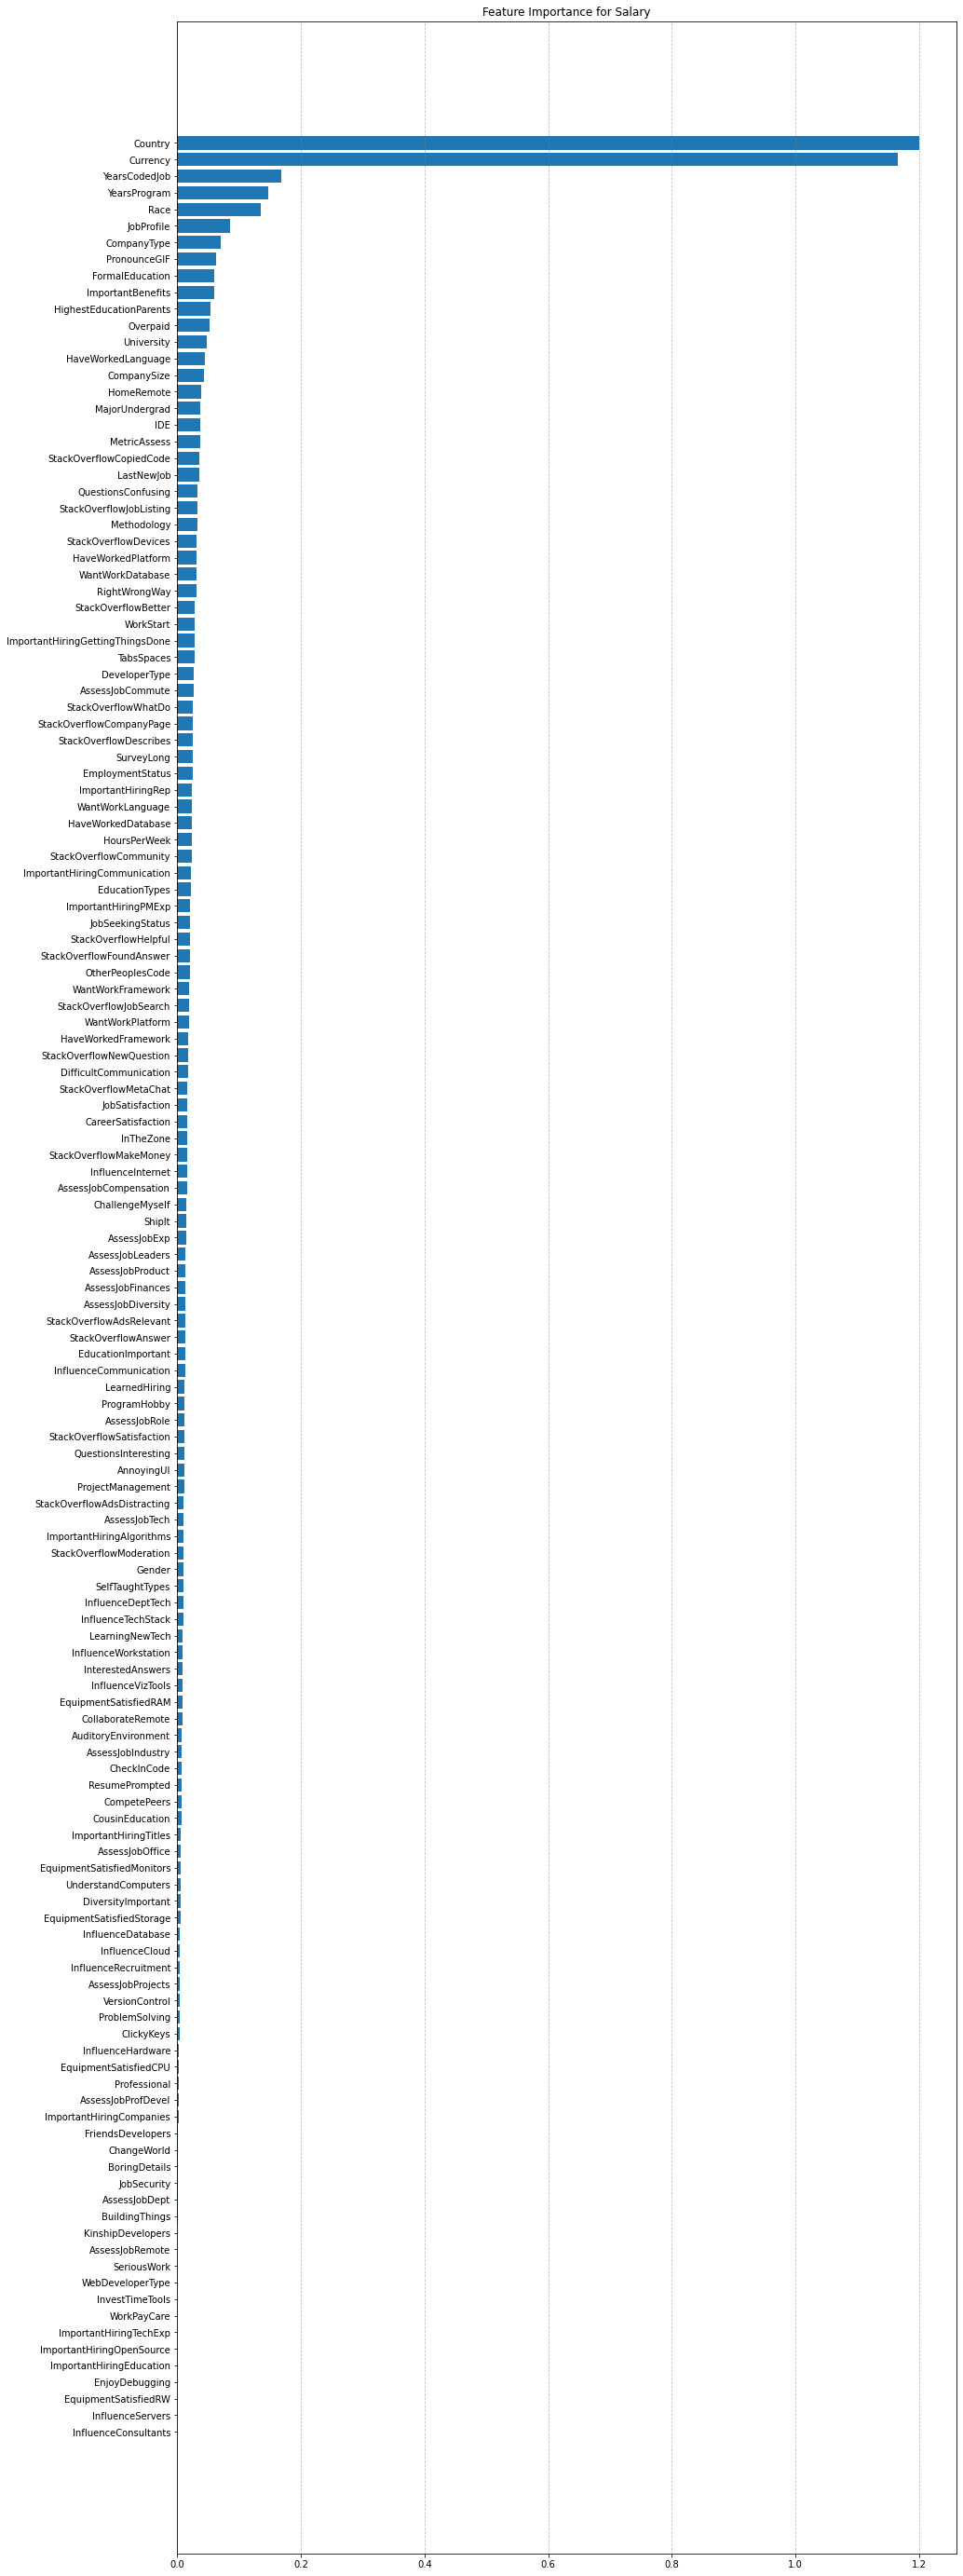

In [79]:
plt.figure(figsize=(15,50))
plt.grid(True, axis='x', color='gray', alpha=0.5, linestyle='--')
plt.barh(*zip(*fs_score.items()))
plt.gca().invert_yaxis()
plt.title('Feature Importance for Salary')
plt.show()

### 3.2.2 Model For JobSatisfaction

In [80]:
target = 'JobSatisfaction'
fs_score = get_feature_score(new_df, target)
fs_score

{'CareerSatisfaction': 0.3120350641256415,
 'JobSeekingStatus': 0.09230859697402494,
 'HoursPerWeek': 0.0741328312565761,
 'Overpaid': 0.04919340546029716,
 'AssessJobOffice': 0.04340583270356202,
 'AssessJobLeaders': 0.04236842833589982,
 'AssessJobDiversity': 0.0418033289611337,
 'AssessJobTech': 0.04139099708027416,
 'AssessJobFinances': 0.04102330850529157,
 'AssessJobDept': 0.04031596201106602,
 'AssessJobExp': 0.03968587436776794,
 'AssessJobIndustry': 0.03797250352198933,
 'AssessJobRemote': 0.037326501985849525,
 'AssessJobProjects': 0.0352378146099257,
 'AssessJobRole': 0.03409791031437415,
 'StackOverflowJobSearch': 0.0310005534404052,
 'AssessJobCommute': 0.030070094340286957,
 'AssessJobProduct': 0.029387814922214872,
 'AssessJobProfDevel': 0.028929404030025196,
 'AssessJobCompensation': 0.02660874859931539,
 'InfluenceWorkstation': 0.02657416376179178,
 'InfluenceCommunication': 0.02425084424587798,
 'KinshipDevelopers': 0.02118615742961527,
 'EquipmentSatisfiedCPU': 0.020

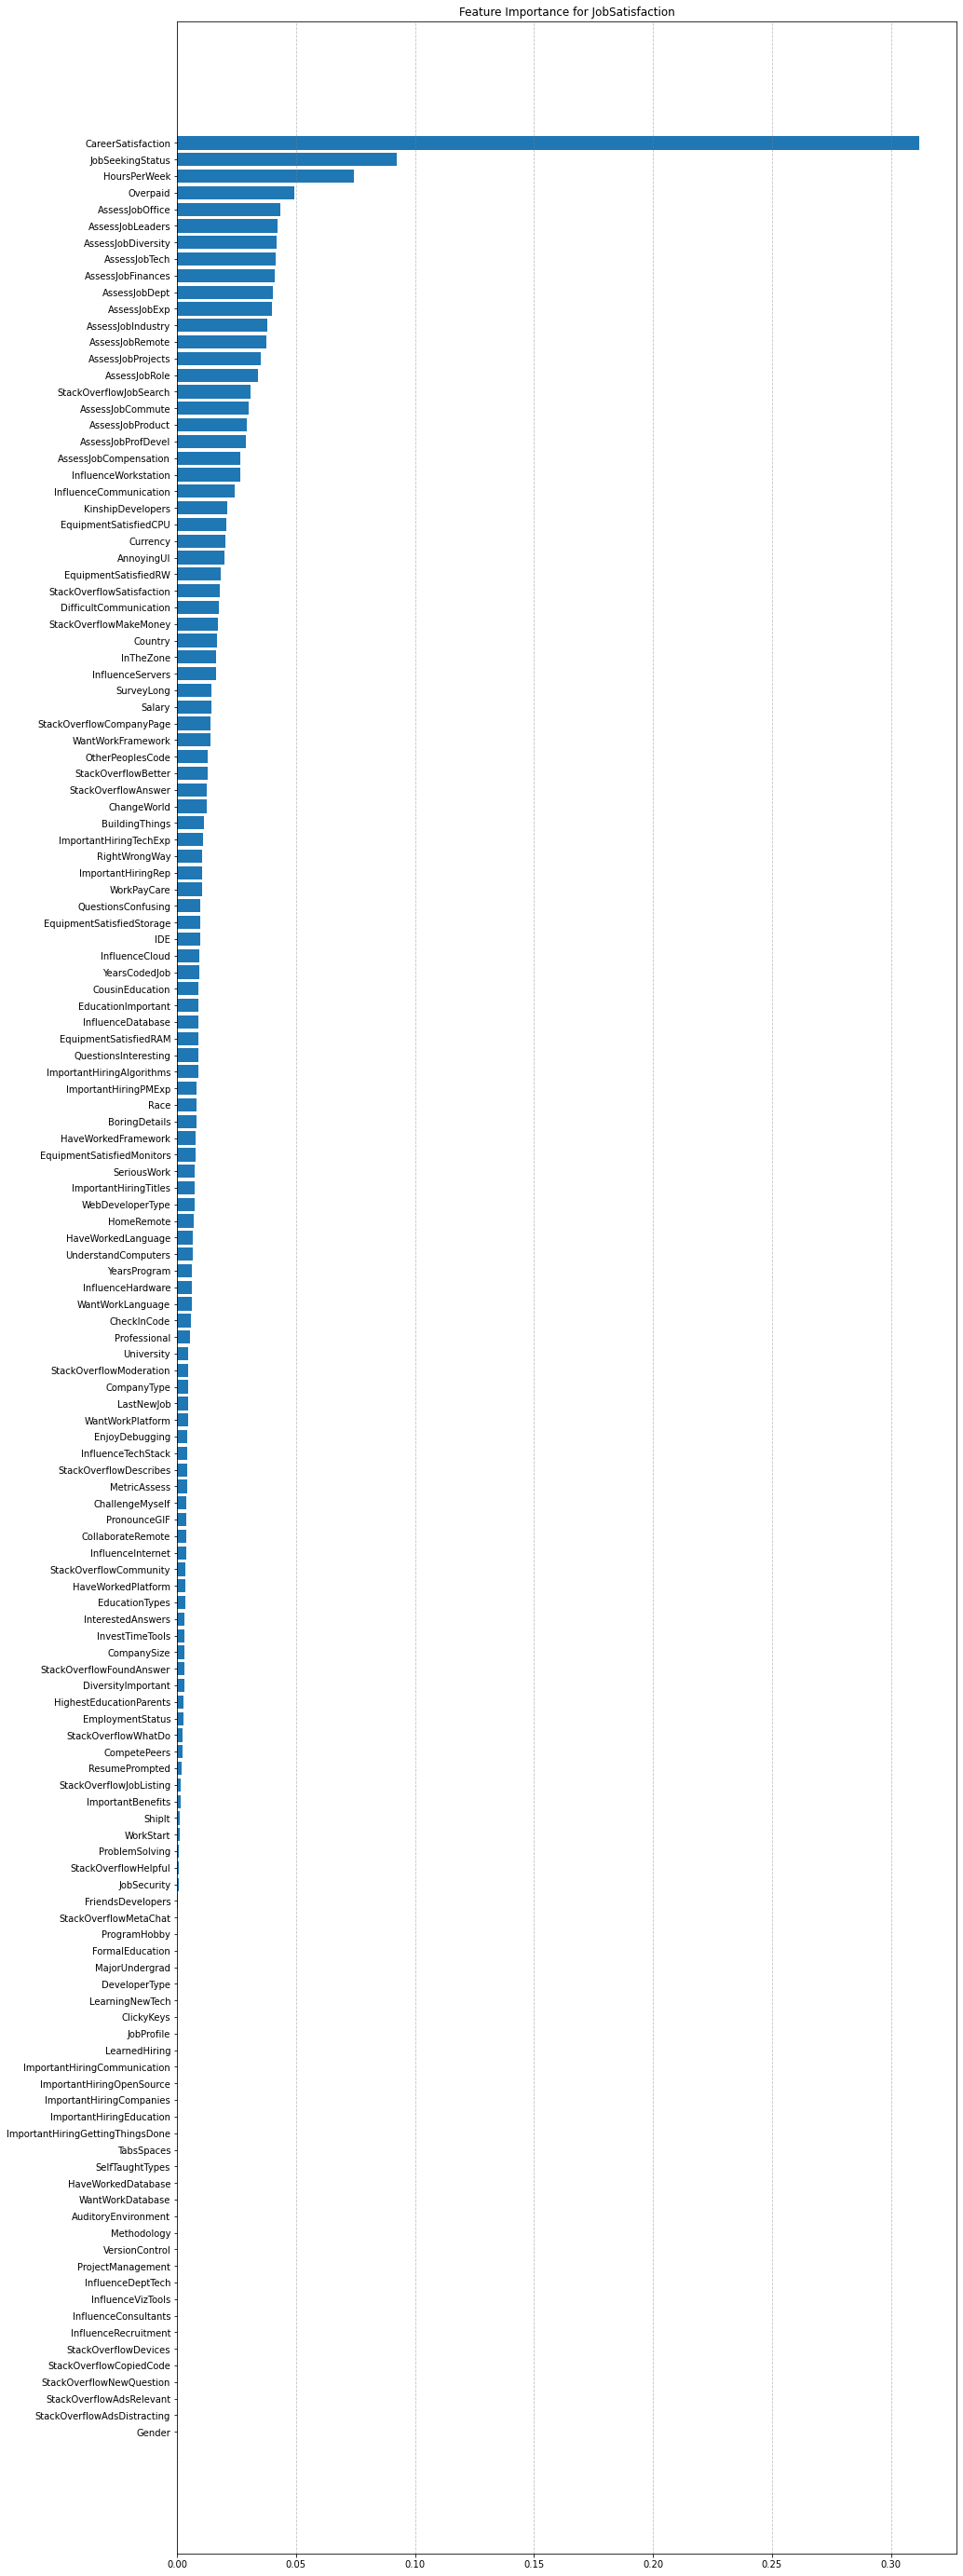

In [81]:
plt.figure(figsize=(15,50))
plt.grid(True, axis='x', color='gray', alpha=0.5, linestyle='--')
plt.barh(*zip(*fs_score.items()))
plt.gca().invert_yaxis()
plt.title(f'Feature Importance for {target}')
plt.show()